# Imports

In [16]:
# ============================================================================
# 02_preprocessing.ipynb
# Data Preprocessing for Multi-Class Diabetes Classification
# Dataset: BRFSS 2015 - Diabetes Health Indicators (3 Classes)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')
# Scale only continuous features
from sklearn.preprocessing import StandardScaler  # noqa: E402

# Add src directory to path
sys.path.append('../src/core')

# Import custom modules
from data_loader import load_raw_data  # noqa: E402
from preprocessing import (  # noqa: E402
    check_data_quality,
    remove_duplicates,
    create_train_test_split,
    scale_features,
    apply_smote,
    save_processed_data
)

# Plot style
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Define output directory
output_dir = "../outputs/figures/preprocessing"
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created: {output_dir}")

# Define processed data directory
processed_data_dir = "../data/processed"
os.makedirs(processed_data_dir, exist_ok=True)
print(f"Processed data directory created: {processed_data_dir}")


Output directory created: ../outputs/figures/preprocessing
Processed data directory created: ../data/processed


# Loading Data

In [17]:
# =============================================================================
# 1. DATA LOADING
# =============================================================================
print("\n" + "="*80)
print("STEP 1: DATA LOADING")
print("="*80)

df = load_raw_data("../data/raw/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv")

print(f"\nInitial Dataset Shape: {df.shape}")
print(f"Total Samples: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1] - 1}")



STEP 1: DATA LOADING
Data loaded: 253680 rows, 22 columns

Initial Dataset Shape: (253680, 22)
Total Samples: 253,680
Total Features: 21


# Data Quality Check

In [18]:
# =============================================================================
# 2. DATA QUALITY CHECK
# =============================================================================
print("\n" + "="*80)
print("STEP 2: DATA QUALITY CHECK")
print("="*80)

quality_report = check_data_quality(df)

print("\nData Quality Report:")
print("-" * 60)
print(f"Missing Values:  {quality_report['missing_values']}")
print(f"Duplicates:      {quality_report['duplicates']:,}")
print(f"Dataset Shape:   {quality_report['shape']}")




STEP 2: DATA QUALITY CHECK

Data Quality Report:
------------------------------------------------------------
Missing Values:  0
Duplicates:      23,899
Dataset Shape:   (253680, 22)


# Duplicate Removal


STEP 3: REMOVE DUPLICATES

Before removing duplicates: 253,680 samples
Duplicates removed: 23899
After removing duplicates:  229,781 samples


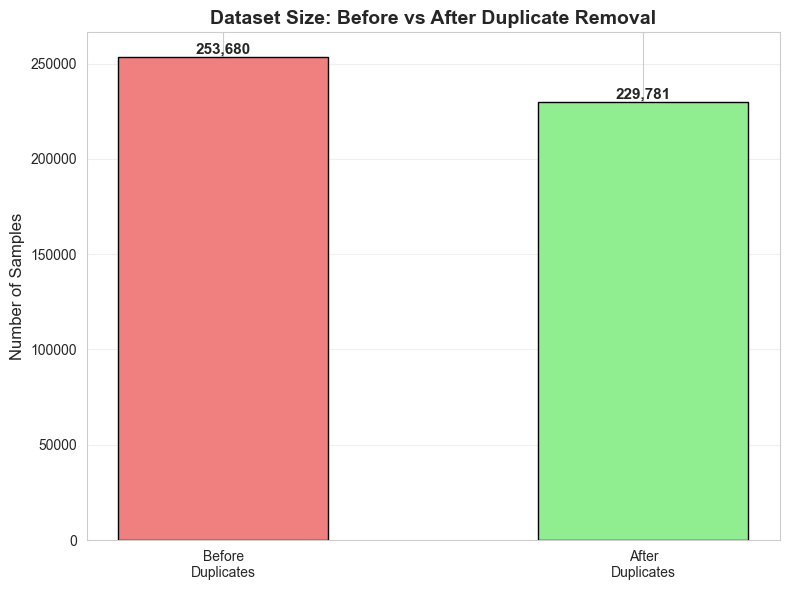


Saved: ../outputs/figures/preprocessing/01_duplicate_removal.png


In [19]:
# =============================================================================
# 3. REMOVE DUPLICATES
# =============================================================================
print("\n" + "="*80)
print("STEP 3: REMOVE DUPLICATES")
print("="*80)

print(f"\nBefore removing duplicates: {df.shape[0]:,} samples")
df_clean = remove_duplicates(df)
print(f"After removing duplicates:  {df_clean.shape[0]:,} samples")

# Visualize duplicate removal
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
categories = ['Before\nDuplicates', 'After\nDuplicates']
counts = [df.shape[0], df_clean.shape[0]]
colors = ['lightcoral', 'lightgreen']

bars = ax.bar(categories, counts, color=colors, edgecolor='black', width=0.5)
ax.set_title('Dataset Size: Before vs After Duplicate Removal', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{output_dir}/01_duplicate_removal.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {output_dir}/01_duplicate_removal.png")


# Separate Features and Target

In [20]:
# =============================================================================
# 4. SEPARATE FEATURES AND TARGET
# =============================================================================
print("\n" + "="*80)
print("STEP 4: SEPARATE FEATURES AND TARGET")
print("="*80)

target_variable = 'Diabetes_012'
features = df_clean.drop(columns=[target_variable])
target = df_clean[target_variable]

print(f"\nFeatures Shape: {features.shape}")
print(f"Target Shape:   {target.shape}")

print("\nTarget Distribution:")
print("-" * 60)
target_counts = target.value_counts().sort_index()
target_percentages = target.value_counts(normalize=True).sort_index() * 100

label_mapping = {0: 'No Diabetes', 1: 'Prediabetes', 2: 'Diabetes'}

for cls in sorted(target.unique()):
    print(f"Class {cls} ({label_mapping[cls]:12s}): "
          f"{target_counts[cls]:7,} ({target_percentages[cls]:5.2f}%)")
    



STEP 4: SEPARATE FEATURES AND TARGET

Features Shape: (229781, 21)
Target Shape:   (229781,)

Target Distribution:
------------------------------------------------------------
Class 0.0 (No Diabetes ): 190,055 (82.71%)
Class 1.0 (Prediabetes ):   4,629 ( 2.01%)
Class 2.0 (Diabetes    ):  35,097 (15.27%)


# Feature Type Categorization

In [21]:
# =============================================================================
# 5. FEATURE TYPE CATEGORIZATION
# =============================================================================
print("\n" + "="*80)
print("STEP 5: FEATURE TYPE CATEGORIZATION")
print("="*80)

binary_features = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
    'DiffWalk', 'Sex'
]

ordinal_features = ['GenHlth', 'Age', 'Education', 'Income']

continuous_features = ['BMI', 'MentHlth', 'PhysHlth']

print("\nFEATURE TYPE BREAKDOWN:")
print("-" * 60)
print("Binary Features (0/1):           {len(binary_features)}")
for f in binary_features:
    print(f"  • {f}")

print("\nOrdinal Features (label-encoded): {len(ordinal_features)}")
print("  • GenHlth (1-5: Excellent to Poor)")
print("  • Age (1-13: 18-24 to 80+)")
print("  • Education (1-6: Never attended to College graduate)")
print("  • Income (1-8: <$10k to $75k+)")

print("\nContinuous/Quasi-continuous:      {len(continuous_features)}")
print("  • BMI (continuous)")
print("  • MentHlth (0-30 days with poor mental health)")
print("  • PhysHlth (0-30 days with poor physical health)")

print("\nENCODING STRATEGY (Industry Standard):")
print("-" * 60)
print("✓ Binary features (0/1):     Already encoded → No change")
print("✓ Ordinal features:          Already label-encoded → No change")
print("✓ Continuous features:       Apply StandardScaler")



STEP 5: FEATURE TYPE CATEGORIZATION

FEATURE TYPE BREAKDOWN:
------------------------------------------------------------
Binary Features (0/1):           {len(binary_features)}
  • HighBP
  • HighChol
  • CholCheck
  • Smoker
  • Stroke
  • HeartDiseaseorAttack
  • PhysActivity
  • Fruits
  • Veggies
  • HvyAlcoholConsump
  • AnyHealthcare
  • NoDocbcCost
  • DiffWalk
  • Sex

Ordinal Features (label-encoded): {len(ordinal_features)}
  • GenHlth (1-5: Excellent to Poor)
  • Age (1-13: 18-24 to 80+)
  • Education (1-6: Never attended to College graduate)
  • Income (1-8: <$10k to $75k+)

Continuous/Quasi-continuous:      {len(continuous_features)}
  • BMI (continuous)
  • MentHlth (0-30 days with poor mental health)
  • PhysHlth (0-30 days with poor physical health)

ENCODING STRATEGY (Industry Standard):
------------------------------------------------------------
✓ Binary features (0/1):     Already encoded → No change
✓ Ordinal features:          Already label-encoded → No change
✓

# Train-Test Split


STEP 6: TRAIN-TEST SPLIT (80/20)
Training Set: 183824 Samples
Test Set: 45957 Samples

Training Set Distribution:
Diabetes_012
0.0    152043
1.0      3703
2.0     28078
Name: count, dtype: int64

Test Set Distribution:
Diabetes_012
0.0    38012
1.0      926
2.0     7019
Name: count, dtype: int64


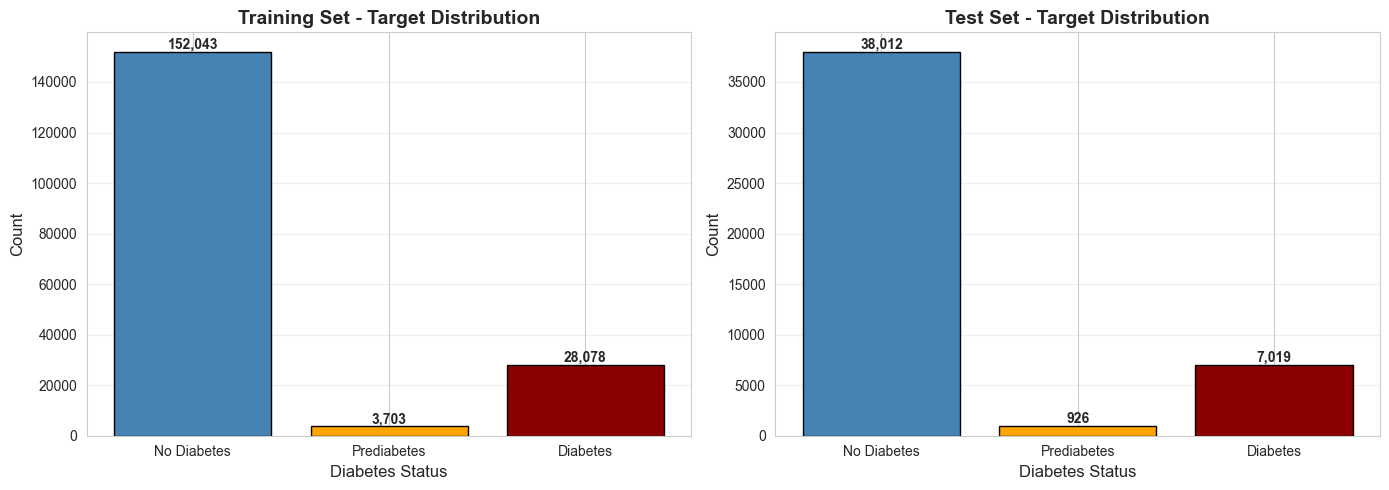


Saved: ../outputs/figures/preprocessing/02_train_test_split.png


In [22]:
# =============================================================================
# 6. TRAIN-TEST SPLIT
# =============================================================================
print("\n" + "="*80)
print("STEP 6: TRAIN-TEST SPLIT (80/20)")
print("="*80)

features_train, features_test, target_train, target_test = create_train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Visualize train-test split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train set distribution
train_counts = target_train.value_counts().sort_index()
axes[0].bar([label_mapping[i] for i in train_counts.index], train_counts.values,
            color=['steelblue', 'orange', 'darkred'], edgecolor='black')
axes[0].set_title('Training Set - Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diabetes Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(train_counts.items()):
    axes[0].text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Test set distribution
test_counts = target_test.value_counts().sort_index()
axes[1].bar([label_mapping[i] for i in test_counts.index], test_counts.values,
            color=['steelblue', 'orange', 'darkred'], edgecolor='black')
axes[1].set_title('Test Set - Target Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Diabetes Status', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(test_counts.items()):
    axes[1].text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{output_dir}/02_train_test_split.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {output_dir}/02_train_test_split.png")


# Feature Scaling (Continuous Features Only)


STEP 7: FEATURE SCALING (CONTINUOUS FEATURES ONLY)

SCALING STRATEGY:
------------------------------------------------------------
Following industry best practices:
  • Binary features (0/1) → No scaling needed
  • Ordinal features (already label-encoded) → No scaling needed
  • Continuous features (BMI, MentHlth, PhysHlth) → StandardScaler

Before Scaling - Continuous Features Statistics:
------------------------------------------------------------
         BMI  MentHlth  PhysHlth
mean  28.689     3.498     4.685
std    6.772     7.702     9.050

After Scaling - Continuous Features Statistics:
------------------------------------------------------------
      BMI  MentHlth  PhysHlth
mean  0.0      -0.0      -0.0
std   1.0       1.0       1.0

Scaled 3 continuous features: ['BMI', 'MentHlth', 'PhysHlth']
Kept 18 binary/ordinal features unchanged


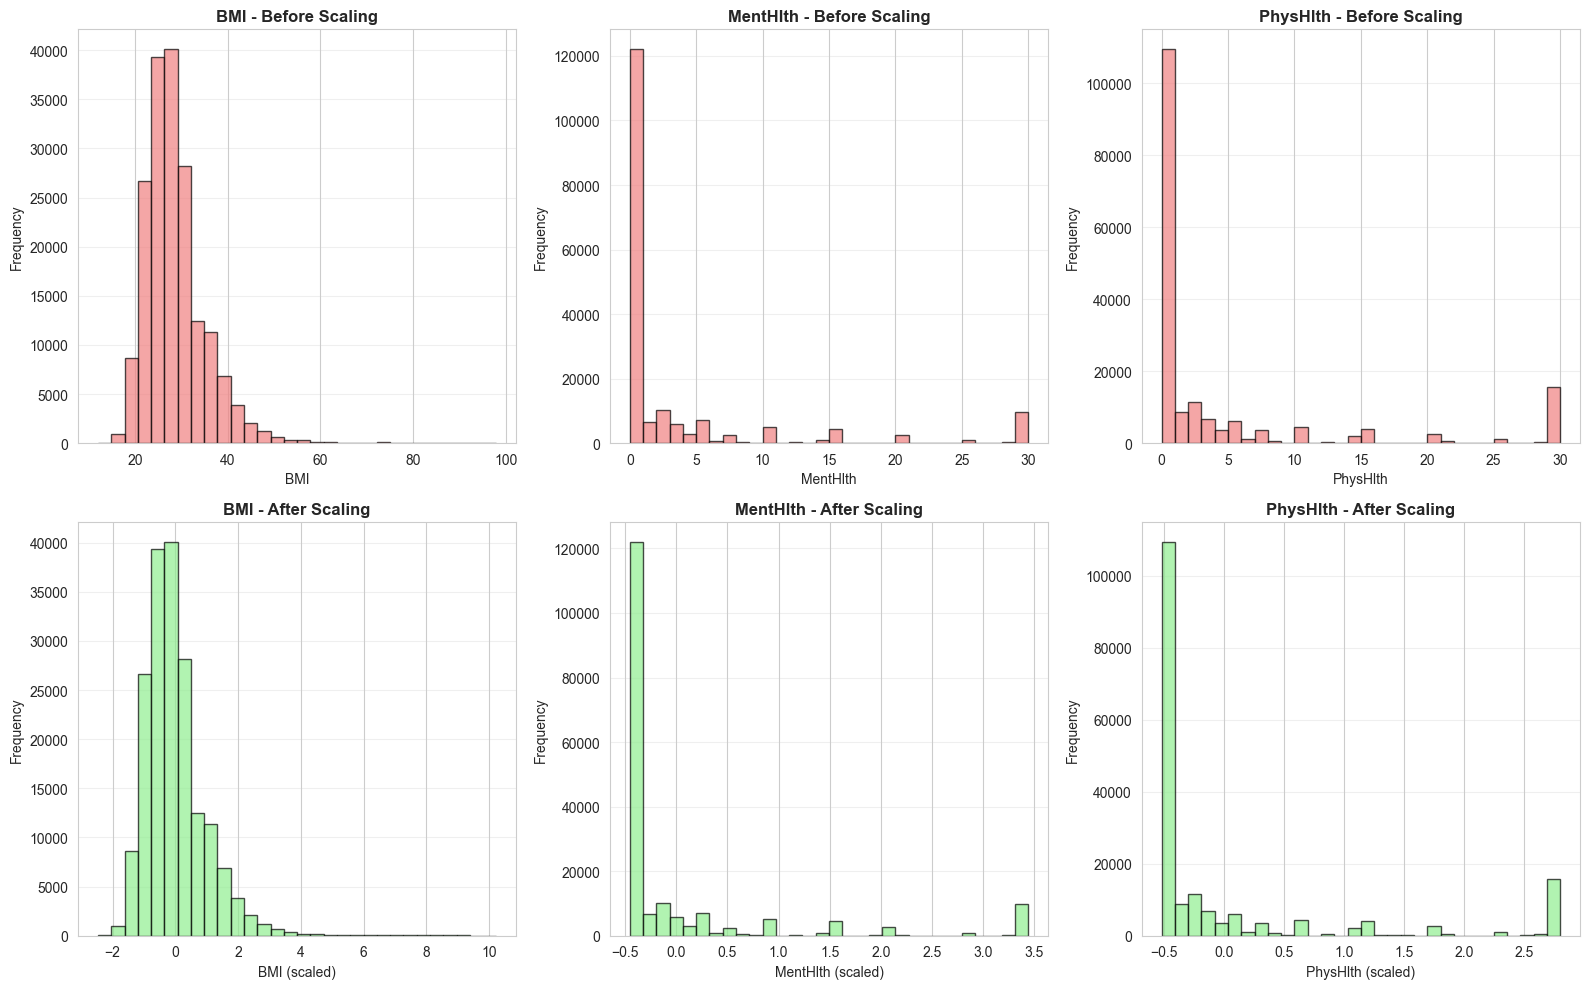


Saved: ../outputs/figures/preprocessing/03_feature_scaling.png


In [23]:
# =============================================================================
# 7. FEATURE SCALING (CONTINUOUS FEATURES ONLY)
# =============================================================================
print("\n" + "="*80)
print("STEP 7: FEATURE SCALING (CONTINUOUS FEATURES ONLY)")
print("="*80)

print("\nSCALING STRATEGY:")
print("-" * 60)
print("Following industry best practices:")
print("  • Binary features (0/1) → No scaling needed")
print("  • Ordinal features (already label-encoded) → No scaling needed")
print("  • Continuous features (BMI, MentHlth, PhysHlth) → StandardScaler")

print("\nBefore Scaling - Continuous Features Statistics:")
print("-" * 60)
print(features_train[continuous_features].describe().loc[['mean', 'std']].round(3))

# Separate continuous and other features
other_features = [col for col in features_train.columns if col not in continuous_features]

scaler = StandardScaler()
train_continuous_scaled = scaler.fit_transform(features_train[continuous_features])
test_continuous_scaled = scaler.transform(features_test[continuous_features])

# Convert to DataFrame
train_continuous_scaled_df = pd.DataFrame(
    train_continuous_scaled, 
    columns=continuous_features, 
    index=features_train.index
)
test_continuous_scaled_df = pd.DataFrame(
    test_continuous_scaled, 
    columns=continuous_features, 
    index=features_test.index
)

# Concatenate scaled continuous features with other features
features_train_scaled = pd.concat([
    train_continuous_scaled_df, 
    features_train[other_features]
], axis=1)

features_test_scaled = pd.concat([
    test_continuous_scaled_df, 
    features_test[other_features]
], axis=1)

# Reorder columns to match original order
features_train_scaled = features_train_scaled[features_train.columns]
features_test_scaled = features_test_scaled[features_test.columns]

print("\nAfter Scaling - Continuous Features Statistics:")
print("-" * 60)
print(features_train_scaled[continuous_features].describe().loc[['mean', 'std']].round(3))

print(f"\nScaled {len(continuous_features)} continuous features: {continuous_features}")
print(f"Kept {len(binary_features) + len(ordinal_features)} binary/ordinal features unchanged")

# Visualize scaling effect on continuous features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for idx, feature in enumerate(continuous_features):
    # Before scaling
    axes[0, idx].hist(features_train[feature], bins=30, color='lightcoral',
                      edgecolor='black', alpha=0.7)
    axes[0, idx].set_title(f'{feature} - Before Scaling', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel(feature, fontsize=10)
    axes[0, idx].set_ylabel('Frequency', fontsize=10)
    axes[0, idx].grid(axis='y', alpha=0.3)
    
    # After scaling
    axes[1, idx].hist(features_train_scaled[feature], bins=30, color='lightgreen',
                      edgecolor='black', alpha=0.7)
    axes[1, idx].set_title(f'{feature} - After Scaling', fontsize=12, fontweight='bold')
    axes[1, idx].set_xlabel(f'{feature} (scaled)', fontsize=10)
    axes[1, idx].set_ylabel('Frequency', fontsize=10)
    axes[1, idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/03_feature_scaling.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {output_dir}/03_feature_scaling.png")


# Class Imbalance Handling


STEP 8: CLASS IMBALANCE HANDLING (SMOTE)

Applying SMOTE to balance classes in training set...
------------------------------------------------------------
Before SMOTE:
Diabetes_012
0.0    152043
1.0      3703
2.0     28078
Name: count, dtype: int64

After SMOTE:
Diabetes_012
0.0    152043
1.0    152043
2.0    152043
Name: count, dtype: int64


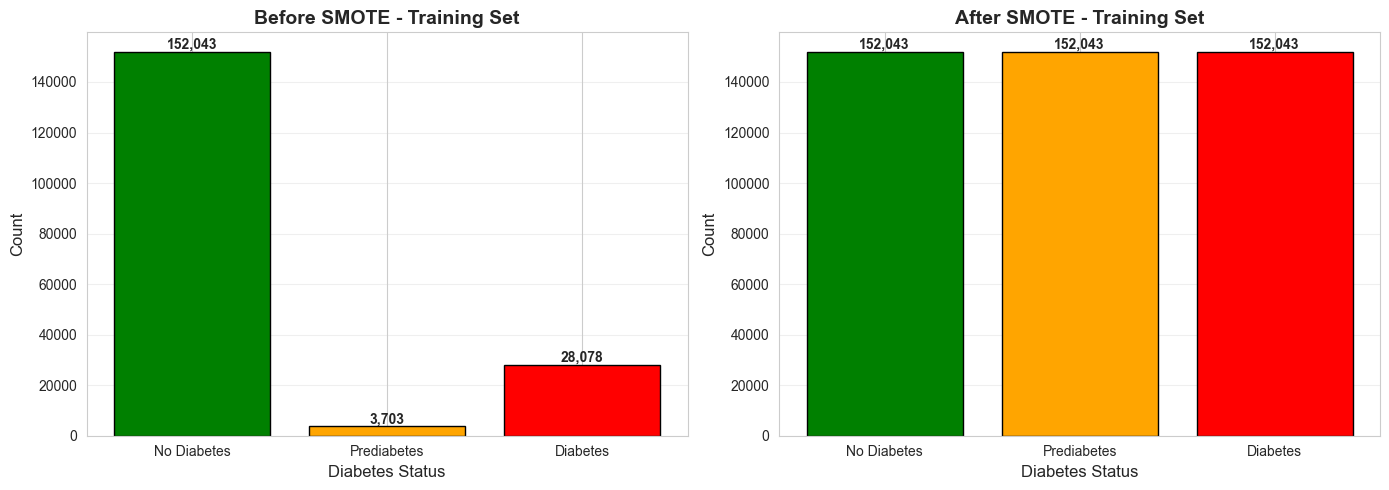


Saved: ../outputs/figures/preprocessing/04_smote_balancing.png


In [24]:
# =============================================================================
# 8. CLASS IMBALANCE HANDLING (SMOTE)
# =============================================================================
print("\n" + "="*80)
print("STEP 8: CLASS IMBALANCE HANDLING (SMOTE)")
print("="*80)

print("\nApplying SMOTE to balance classes in training set...")
print("-" * 60)

features_train_resampled, target_train_resampled = apply_smote(
    features_train_scaled, target_train, random_state=42
)

# Visualize SMOTE effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
before_counts = target_train.value_counts().sort_index()
axes[0].bar([label_mapping[i] for i in before_counts.index], before_counts.values,
            color=['green', 'orange', 'red'], edgecolor='black')
axes[0].set_title('Before SMOTE - Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diabetes Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(before_counts.items()):
    axes[0].text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# After SMOTE
after_counts = pd.Series(target_train_resampled).value_counts().sort_index()
axes[1].bar([label_mapping[i] for i in after_counts.index], after_counts.values,
            color=['green', 'orange', 'red'], edgecolor='black')
axes[1].set_title('After SMOTE - Training Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Diabetes Status', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(after_counts.items()):
    axes[1].text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{output_dir}/04_smote_balancing.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {output_dir}/04_smote_balancing.png")


# Final Data Summary

In [25]:
# =============================================================================
# 9. FINAL DATA SUMMARY
# =============================================================================
print("\n" + "="*80)
print("STEP 9: FINAL DATA SUMMARY")
print("="*80)

print("\nPREPROCESSING SUMMARY:")
print("-" * 60)
print(f"Original Dataset:              {df.shape[0]:,} samples")
print(f"After Duplicate Removal:       {df_clean.shape[0]:,} samples")
print(f"Duplicates Removed:            {df.shape[0] - df_clean.shape[0]:,} samples")

print("\nFEATURE ENGINEERING:")
print("-" * 60)
print(f"Binary Features (unchanged):   {len(binary_features)}")
print(f"Ordinal Features (unchanged):  {len(ordinal_features)}")
print(f"Continuous Features (scaled):  {len(continuous_features)}")
print(f"Total Features:                {features_train.shape[1]}")

print("\nTRAIN-TEST SPLIT:")
print("-" * 60)
print(f"Training Set (Before SMOTE):   {features_train.shape[0]:,} samples")
print(f"Training Set (After SMOTE):    {len(target_train_resampled):,} samples")
print(f"Test Set:                      {features_test.shape[0]:,} samples")

print("\nCLASS DISTRIBUTION (TRAINING SET):")
print("-" * 60)
print("Before SMOTE:")
for cls in sorted(target_train.unique()):
    count = before_counts[cls]
    pct = count / len(target_train) * 100
    print(f"  Class {cls} ({label_mapping[cls]:12s}): {count:7,} ({pct:5.2f}%)")

print("\nAfter SMOTE:")
for cls in sorted(pd.Series(target_train_resampled).unique()):
    count = after_counts[cls]
    pct = count / len(target_train_resampled) * 100
    print(f"  Class {cls} ({label_mapping[cls]:12s}): {count:7,} ({pct:5.2f}%)")

print("\nCLASS DISTRIBUTION (TEST SET):")
print("-" * 60)
for cls in sorted(target_test.unique()):
    count = test_counts[cls]
    pct = count / len(target_test) * 100
    print(f"  Class {cls} ({label_mapping[cls]:12s}): {count:7,} ({pct:5.2f}%)")



STEP 9: FINAL DATA SUMMARY

PREPROCESSING SUMMARY:
------------------------------------------------------------
Original Dataset:              253,680 samples
After Duplicate Removal:       229,781 samples
Duplicates Removed:            23,899 samples

FEATURE ENGINEERING:
------------------------------------------------------------
Binary Features (unchanged):   14
Ordinal Features (unchanged):  4
Continuous Features (scaled):  3
Total Features:                21

TRAIN-TEST SPLIT:
------------------------------------------------------------
Training Set (Before SMOTE):   183,824 samples
Training Set (After SMOTE):    456,129 samples
Test Set:                      45,957 samples

CLASS DISTRIBUTION (TRAINING SET):
------------------------------------------------------------
Before SMOTE:
  Class 0.0 (No Diabetes ): 152,043 (82.71%)
  Class 1.0 (Prediabetes ):   3,703 ( 2.01%)
  Class 2.0 (Diabetes    ):  28,078 (15.27%)

After SMOTE:
  Class 0.0 (No Diabetes ): 152,043 (33.33%)
  Cla

# Save Processed Data

In [26]:
# =============================================================================
# 10. SAVE PROCESSED DATA
# =============================================================================
print("\n" + "="*80)
print("STEP 10: SAVE PROCESSED DATA")
print("="*80)

# Save cleaned data (before split)
df_clean_path = f"{processed_data_dir}/diabetes_012_cleaned.csv"
df_clean.to_csv(df_clean_path, index=False)
print(f"Cleaned data saved: {df_clean_path}")

# Save train-test splits (scaled continuous features only)
features_train_scaled.to_csv(f"{processed_data_dir}/features_train_scaled.csv", index=False)
features_test_scaled.to_csv(f"{processed_data_dir}/features_test_scaled.csv", index=False)
target_train.to_csv(f"{processed_data_dir}/target_train.csv", index=False)
target_test.to_csv(f"{processed_data_dir}/target_test.csv", index=False)

print(f"Training features (scaled) saved: {processed_data_dir}/features_train_scaled.csv")
print(f"Test features (scaled) saved:     {processed_data_dir}/features_test_scaled.csv")
print(f"Training target saved:             {processed_data_dir}/target_train.csv")
print(f"Test target saved:                 {processed_data_dir}/target_test.csv")

# Save SMOTE-resampled training data
features_train_resampled_df = pd.DataFrame(features_train_resampled, columns=features_train.columns)
target_train_resampled_df = pd.DataFrame(target_train_resampled, columns=['Diabetes_012'])

features_train_resampled_df.to_csv(f"{processed_data_dir}/features_train_smote.csv", index=False)
target_train_resampled_df.to_csv(f"{processed_data_dir}/target_train_smote.csv", index=False)

print(f"Training features (SMOTE) saved:   {processed_data_dir}/features_train_smote.csv")
print(f"Training target (SMOTE) saved:     {processed_data_dir}/target_train_smote.csv")



STEP 10: SAVE PROCESSED DATA
Cleaned data saved: ../data/processed/diabetes_012_cleaned.csv
Training features (scaled) saved: ../data/processed/features_train_scaled.csv
Test features (scaled) saved:     ../data/processed/features_test_scaled.csv
Training target saved:             ../data/processed/target_train.csv
Test target saved:                 ../data/processed/target_test.csv
Training features (SMOTE) saved:   ../data/processed/features_train_smote.csv
Training target (SMOTE) saved:     ../data/processed/target_train_smote.csv


# Visualization Summary

In [27]:
# =============================================================================
# 11. VISUALIZATION SUMMARY
# =============================================================================
print("\n" + "="*80)
print("VISUALIZATION SUMMARY")
print("="*80)

print("\nVISUALIZATIONS SAVED:")
print("-" * 60)
print(f"  • {output_dir}/01_duplicate_removal.png")
print(f"  • {output_dir}/02_train_test_split.png")
print(f"  • {output_dir}/03_feature_scaling.png")
print(f"  • {output_dir}/04_smote_balancing.png")

print("\n" + "="*80)
print("PREPROCESSING COMPLETED SUCCESSFULLY")
print("="*80)

print("\nNEXT STEPS:")
print("1. Run 03_modeling.ipynb to train machine learning models")
print("2. Evaluate model performance on test set")
print("3. Compare models and select the best one")



VISUALIZATION SUMMARY

VISUALIZATIONS SAVED:
------------------------------------------------------------
  • ../outputs/figures/preprocessing/01_duplicate_removal.png
  • ../outputs/figures/preprocessing/02_train_test_split.png
  • ../outputs/figures/preprocessing/03_feature_scaling.png
  • ../outputs/figures/preprocessing/04_smote_balancing.png

PREPROCESSING COMPLETED SUCCESSFULLY

NEXT STEPS:
1. Run 03_modeling.ipynb to train machine learning models
2. Evaluate model performance on test set
3. Compare models and select the best one
